In [263]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import torchaudio

In [264]:
# Helpers

def apply_stft(tensor, frame_length=256, frame_step=64):
    return tf.signal.stft(tensor, frame_length=frame_length, frame_step=frame_step)

def apply_istft(tensor, frame_length=256, frame_step=64):
    return tf.signal.inverse_stft(tensor, frame_length=frame_length, frame_step=frame_step)

def complex_from_polar(magnitude, phase):
    return tf.complex(magnitude, 0.0) * tf.exp(tf.complex(0.0, phase))

def get_num_samples_for_num_frames(num_frames, frame_length=256, hop_length=64):
    return (num_frames - 1) * hop_length + frame_length

def plot_stft(stft, frame_step=64, sr=16000):

    # By convention time is x-axis.
    stft = tf.transpose(stft)

    num_bins, num_frames = stft.shape

    time_tick_spacing = num_frames // 5
    frequency_tick_spacing = num_bins // 4

    duration_seconds = num_frames * frame_step / sr
    time = np.linspace(0, duration_seconds, num_frames, endpoint=False)
    frequency = np.linspace(0, sr / 2, num_bins)

    time = time[::time_tick_spacing]
    frequency = frequency[::frequency_tick_spacing]

    time_ticks = np.arange(len(time)) * time_tick_spacing
    frequency_ticks = np.arange(len(frequency)) * frequency_tick_spacing

    plt.imshow(stft, origin='lower', aspect='auto')
    plt.xticks(time_ticks, labels=time)
    plt.yticks(frequency_ticks, labels=frequency)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")

def get_rms(x):
    return np.mean(np.sqrt(x ** 2))

def get_segments_above_threshold(dataset, num_samples, threshold_db):
    segments = []
    for audio in dataset:

        audio = audio[0]
        
        # Chop audio into slices.
        num_segments = len(audio) // num_samples
        audio = audio[:num_segments * num_samples]
        as_slices = audio.reshape(num_segments, num_samples)

        for i in range(num_segments):
            candidate = as_slices[i, :]
            rms = get_rms(candidate)
            level_db = 20 * np.log10(rms)

            if level_db >= threshold_db:
                segments.append(candidate)

    return segments

def reconstruction_snr(y, y_hat):

    signal = tf.reduce_sum(y ** 2, axis=1)
    noise = tf.reduce_sum((y - y_hat) ** 2, axis=1)
    
    return 10 * np.log10(signal / noise)

In [265]:
# For default dataset, set `url="train-clean-100"`
dataset = torchaudio.datasets.LIBRISPEECH("./data", url="dev-clean", download=True)

datum = next(iter(dataset))
sr = datum[1]

num_samples = get_num_samples_for_num_frames(num_frames=129)

audio_in = [audio[0].numpy() for audio in dataset]
audio_in = get_segments_above_threshold(audio_in, num_samples=num_samples, threshold_db=-30)
dataset = tf.convert_to_tensor(audio_in)
dataset = apply_stft(dataset)

/var/folders/b1/m5y5wflj5c98rzd65cdc_l5h0000gn/T/ipykernel_47824/4013527012.py:58: RuntimeWarning: divide by zero encountered in log10
  level_db = 20 * np.log10(rms)


In [266]:
X = tf.abs(dataset)
Y = tf.math.angle(dataset)

# Synthesize prediction.
Y_hat = tf.random.normal(shape=Y.shape)

y = apply_istft(complex_from_polar(X, Y))
y_hat = apply_istft(complex_from_polar(X, Y_hat))

reconstruction_snr(y, y_hat).mean()

-0.68432164

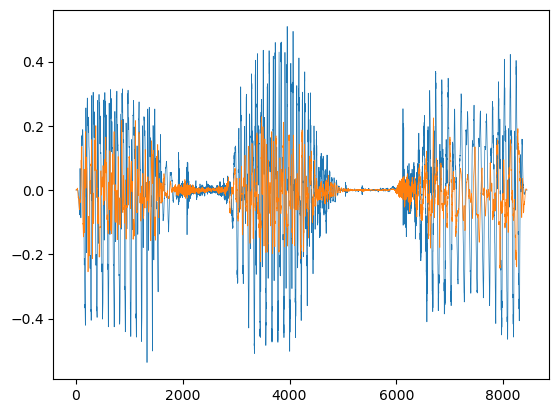

0.11064963042736053	0.04327757656574249


In [267]:
idx = 500
plt.plot(y[idx], linewidth=0.5)
plt.plot(y_hat[idx], linewidth=0.5)
plt.show()

print(f"{get_rms(y[idx])}\t{get_rms(y_hat[idx])}")


ipd.display(ipd.Audio(y[idx], rate=sr))
ipd.display(ipd.Audio(y_hat[idx], rate=sr))

Text(0.5, 1.0, 'Phase (unwrapped)')

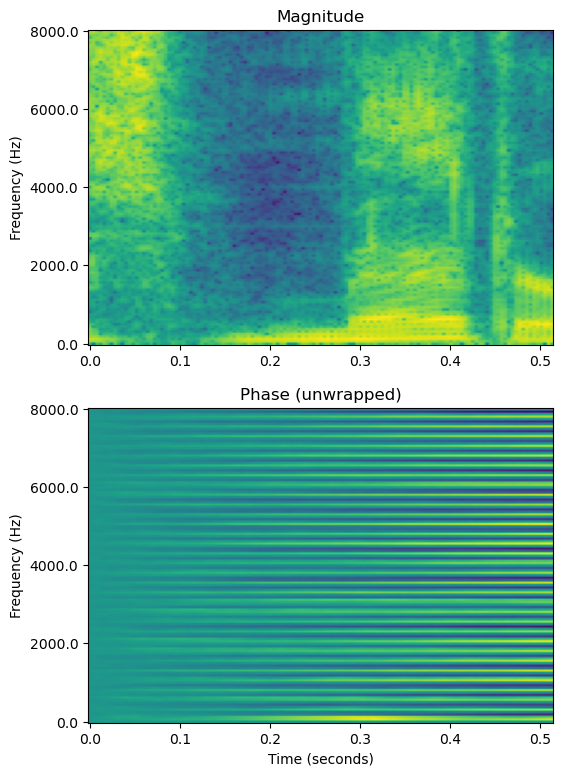

In [268]:
# Plot example.
datum = dataset[15, ...]

plt.figure(figsize=(6, 9))

plt.subplot(2, 1, 1)
plot_stft(tf.math.log(tf.abs(datum)))
plt.xlabel("")
plt.title("Magnitude")

plt.subplot(2, 1, 2)
plot_stft(np.unwrap(tf.math.angle(datum), axis=0))
plt.title("Phase (unwrapped)")